In [1]:
import numpy as np
import matplotlib.pyplot as plt
import maxflow
from math import sqrt

In [224]:
from diffpy.structure import Atom, Lattice, Structure
from orix import plot
from orix.crystal_map import CrystalMap, Phase, PhaseList
from orix.io import load, save
from orix.quaternion import Orientation, Rotation, symmetry, Misorientation
from orix.vector import Vector3d

In [3]:
from loadAng import loadAng, getLibraryPhaseList

In [6]:
dataPath = 'data/'
# fileName = 'ferrite.ang' ### hexgrid
fileName = 'steel_ebsd.ang' ### squaregrid
target = dataPath + fileName
MaterialName = 'Ferrite'

In [44]:
# xmap = load(dataPath + fileName) ### currently does not handle 

GRID, NCOLS_ODD, NCOLS_EVEN, NROWS, numEBSDColumns = loadAng(target)
NCOLS_ODD = int(NCOLS_ODD)
NCOLS_EVEN = int(NCOLS_EVEN)
NROWS = int(NROWS)
numEBSDColumns = int(numEBSDColumns)

print(GRID, NCOLS_ODD, NCOLS_EVEN, NROWS, numEBSDColumns)

if numEBSDColumns == 10:
    euler1, euler2, euler3, x, y, iq, ci, phase_id, sem, fit = np.loadtxt(target, unpack=True)
else:
    print('TODO handle more/fewer columns')

euler_angles = np.column_stack((euler1, euler2, euler3))
rotations = Rotation.from_euler(euler_angles)
properties = dict(iq=iq, dp=ci)

print(euler_angles.shape)

phase_list = getLibraryPhaseList('Ferrite')

# Create a CrystalMap instance
xmap2 = CrystalMap(
    rotations=rotations,
    phase_id=phase_id,
    x=x,
    y=y,
    phase_list=phase_list,
    prop=properties,
)
xmap2.scan_unit = "um"

print(xmap2)

ckey_m3m = plot.IPFColorKeyTSL(xmap2.phases["ferrite"].point_group, direction=Vector3d.zvector())
rgb_fe = ckey_m3m.orientation2color(xmap2["ferrite"].orientations)

0 # TEM_PIXperUM          1.000000

1 # x-star                0.000000

2 # y-star                0.000000

3 # z-star                0.000000

4 # WorkingDistance       0.000000

5 #

6 # Phase 0

7 # MaterialName  	Ferrite

8 # Formula     	

9 # Info 		

10 # Symmetry              129

11 # LatticeConstants       2.870 2.870 2.870  90.000  90.000  90.000

12 # NumberFamilies        0

13 # ElasticConstants 	0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

14 # ElasticConstants 	0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

15 # ElasticConstants 	0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

16 # ElasticConstants 	0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

17 # ElasticConstants 	0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

18 # ElasticConstants 	0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

19 # Categories0 0 0 0 0 

20 #

21 # GRID: SqrGrid

22 # XSTEP: 0.500000

23 # YSTEP: 0.500000

24 # NCOLS_ODD: 305

25 # NCOLS_EVEN: 305

2

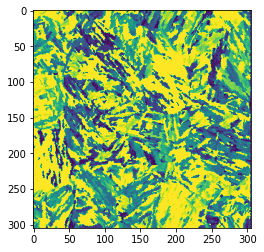

In [8]:
################################
### start building structure to feed into network
### build square array of hex grid points for graph cut
### populate pixels with R channel of orientation image
### leave non-indexed or other phases as zeros

if GRID == 'HexGrid':

    nodeDataArr = np.zeros((NROWS, NCOLS_ODD))

    cRow = 0
    cID = 0

    for pair in np.arange(int(NROWS/2)):

        nodeDataArr[cRow, :NCOLS_EVEN] = rgb_fe[cID:cID+NCOLS_EVEN][:,0] ### even
        cRow += 1
        cID = cID+NCOLS_EVEN

        nodeDataArr[cRow, :NCOLS_ODD] = rgb_fe[cID:cID+NCOLS_ODD][:,0] ### odd
        cRow += 1
        cID = cID+NCOLS_ODD

        # print(cRow, pair)

    plt.imshow(nodeDataArr)
    axes=plt.gca()
    axes.set_aspect(0.5)
    plt.show()

elif GRID == 'SqrGrid':
    ### squaregrid data for graphcut

    nodeData2 = np.zeros((xmap2.id.shape[0], 1))
    ferriteIDs =  xmap2['ferrite'].id
    ferriteGray = rgb_fe[:,0]
    failCounter = 0

    for i in xmap2.id:
        # print(i)
        try:
            # print(i)
            idx = np.where(ferriteIDs == i)[0][0]
            nodeData2[i] = ferriteGray[idx]
        except:
            # print('no value', failCounter)
            failCounter += 1

    n = np.round(sqrt(xmap2.id.shape[0])).astype(int)
    nodeDataArr = np.reshape(nodeData2, (n,n))

    plt.imshow(nodeDataArr)
    plt.show()

In [186]:
### start graphcut

ip_weight = 0.01 ### max > ip_weight > min of data as a place to start

g = maxflow.GraphFloat()
if GRID == 'HexGrid':
    nodeids = g.add_grid_nodes((NROWS, NCOLS_ODD))
    structure = np.array([[0, 1, 1],
                      [1, 0, 1],
                      [0, 1, 1]]) ### struct for hex grid
elif GRID == 'SqrGrid':
    nodeids = g.add_grid_nodes((n,n))
    # structure = maxflow.vonNeumann_structure(ndim=2, directed=True) ### square grid structure
    structure = np.array([[0, 1, 0],
                          [1, 0, 1],
                          [0, 1, 0]]) ### struct for square grid
    
g.add_grid_edges(nodeids, ip_weight, structure=structure)
g.add_grid_tedges(nodeids, nodeDataArr, 1-nodeDataArr)

# g.maxflow()

# sgm = g.get_grid_segments(nodeids)
# print(np.sum(sgm))
# img2 = np.int_(np.logical_not(sgm))

# plt.imshow(img2)
# if GRID == 'HexGrid':
#     axes=plt.gca()
#     axes.set_aspect(0.5)
# plt.show()

In [226]:
import networkx as nx
import scipy.sparse as sp
C = g.get_nx_graph()

AA = nx.to_scipy_sparse_array(C)
sparseUpperArr = sp.triu(AA)

u,v,wt = sp.find(sparseUpperArr)
connectivity = np.asanyarray([u,v])

#%%
sink = np.amax(connectivity.ravel())
source = sink-1
source_edges = np.any(connectivity==source,axis=0)
sink_edges = np.any(connectivity==sink, axis=0)
out_plane_loc = np.any(np.vstack([source_edges, sink_edges]), axis=0)
connectivity2 = connectivity[:, ~out_plane_loc]

#%%
o1 = xmap2.rotations[connectivity2[0,:]]
o2 = xmap2.rotations[connectivity2[1,:]]

m = Misorientation([o1.data, o2.data])
m.symmetry = (symmetry.Oh, symmetry.Oh)
m = m.map_into_symmetry_reduced_zone()

#m = (~o1).outer(o2)

#%%
m2 = m.map_into_symmetry_reduced_zone()
D2 = m2.angle

In [232]:
np.max(D2)

1.0888098393322103

In [231]:
from orix.io import load
from orix.quaternion import Rotation
from scipy.spatial.transform import Rotation as R

import numpy as np
# load up a thingie
# ebsd = load("AF_001.ang")
# just a tiny example of getting misorientation angles
ebsd = xmap2
sp_R = R.from_euler('ZXZ', ebsd.rotations.to_euler())
o1 = sp_R[:-1:2]
o2 = sp_R[1::2]
# this line gets the misorientation (but NOT wiht symmetry considerations,
# got to code that part up still)
mis = R.__mul__(o1, o2.inv())
# Now we just need to shave some lines off the tops and bottoms and flatten arrays
# to get left-right, up-down, and hex-corner pairs
ori_l = R.from_euler('ZXZ', ebsd.rotations.reshape(n, n)[1:,:].flatten().to_euler())
ori_r = R.from_euler('ZXZ', ebsd.rotations.reshape(n, n)[:-1,:].flatten().to_euler())
ori_u = R.from_euler('ZXZ', ebsd.rotations.reshape(n, n)[:,1:].flatten().to_euler())
ori_d = R.from_euler('ZXZ', ebsd.rotations.reshape(n, n)[:,:-1].flatten().to_euler())
ori_hex = R.from_euler('ZXZ', ebsd.rotations.reshape(n, n)[1:,1:].flatten().to_euler())
ori_hex_2 = R.from_euler('ZXZ', ebsd.rotations.reshape(n, n)[:-1,:-1].flatten().to_euler())
# misorientation connections
lr_mis = R.__mul__(ori_l, ori_r.inv()).magnitude().reshape(n-1, n)
ud_mis = R.__mul__(ori_u, ori_d.inv()).magnitude().reshape(n, n-1)
hex_mis = R.__mul__(ori_hex, ori_hex_2.inv()).magnitude().reshape(n-1, n-1)

In [187]:
import networkx as nx
import scipy.sparse as sp

In [188]:
C = g.get_nx_graph()
sparseArr = nx.to_scipy_sparse_array(C)
sparseUpperArr = sp.triu(sparseArr)


In [189]:
adjArr = sp.csr_matrix.todense(sparseUpperArr)
print(adjArr.shape)


(93027, 93027)


In [190]:
print(nodeids.shape)

(305, 305)


In [198]:
u, v, wt = sp.find(sparseArr)
connectArr = np.asanyarray([u,v])
print(connectArr.shape)

(2, 463905)


In [199]:
np.sum(connectArr.ravel()==93026)

33647

In [200]:
sumArr = np.zeros(93027)

for i in np.arange(93027):
    sumArr[i] = np.sum(connectArr.ravel()==i)

In [201]:
print(np.unique(sumArr))

[5.0000e+00 7.0000e+00 9.0000e+00 3.3647e+04 5.9378e+04]


In [223]:
idx = 3
print(np.where(sumArr == np.unique(sumArr)[idx])[0].shape)
print(np.where(sumArr == np.unique(sumArr)[idx]))

(1,)
(array([93026]),)


In [74]:
o1 = xmap2.rotations[connectArr[:,0]]
o2 = xmap2.rotations[connectArr[:,1]]
m = (~o1).outer(o2)

In [49]:
print(m)

Rotation (2, 2)
[[[-0.4519  0.4678 -0.2757  0.7077]
  [-0.8852 -0.058   0.3118  0.3404]]

 [[ 1.      0.      0.      0.    ]
  [ 0.5278  0.7549 -0.1847  0.3427]]]


In [50]:
o = Orientation(m, symmetry='m-3m')

TypeError: Value must be an instance of orix.quaternion.Symmetry.

In [62]:
### start graphcut

ip_weight = 0.01 ### max > ip_weight > min of data as a place to start

tempArr = np.ones((5,5))

g = maxflow.GraphFloat()
nodeids = g.add_grid_nodes((5,5))
structure = maxflow.vonNeumann_structure(ndim=2, directed=True) ### square grid structure
    
g.add_grid_edges(nodeids, ip_weight)
g.add_grid_tedges(nodeids, tempArr, 1-tempArr)

# g.maxflow()

C = g.get_nx_graph()


In [63]:
print(C)

DiGraph with 27 nodes and 105 edges
